In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from my_utils import *
from utils import *
from torch_dataset import DetectionDataset
from engine import evaluate

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as pil 

from random import shuffle
import cv2
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
data_path = 'SVHN_dataset'
model_path = 'models'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading data from the pickle file we created

In [4]:
train_data, test_data = load_pickle(os.path.join(data_path, 'SVHN_metadata.pickle'))

Creating a PyTorch dataset and dataloader for the test set

In [5]:
data_transforms = transforms.Compose([transforms.ToTensor()])

In [6]:
dataset = DetectionDataset(test_data, os.path.join(data_path, 'test'), data_transforms)

In [7]:
test_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

Loading in a trained model

In [18]:
#model_name = 'faster_rcnn_step_3_Epoch9.tar'
model_name = 'best_model.tar'
model, optimizer, criterion, epoch, device = load_model(os.path.join(model_path, model_name))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): DigitModel(
    (block1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
    (block3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPoo

In [19]:
def calc_acc(target, pred):
    '''Calculates both the sequence and digit wise accuracies for an image and its prediction'''
    
    targ_len = len(target)
    pred_len = len(pred)
    
    # If target label is not the same length as the prediction, sequence prediction is clearly wrong
    if targ_len != pred_len:
        seq_correct = 0
    # If prediction and target are the same length, sequence is correct if these simply match
    else:
        seq_correct = int(torch.equal(target.cpu(), pred.cpu()))
    
    # Count the number of digits in the prediction label that match the target label
    digits_correct  = 0
    smaller = min(targ_len, pred_len)
    for i in range(smaller):
        digits_correct += int(target[i].cpu() == pred[i].cpu())

    return seq_correct, digits_correct

In [20]:
def order_preds(labels, bboxs):
    '''Orders predictions from left to right, based on their bounding box location'''
    
    if len(labels) < 2:
        return labels
    
    ordered = [x.item() for _,x in sorted(zip(bboxs[:, 2], labels))]
        
    return torch.tensor(ordered)

In [21]:
def IoU(gt_box, pred_box):
    '''Calculates the Intersection over Union score of two bounding boxes'''
    
    # Determine the coordinates of the intersection rectangle
    x1 = max(gt_box[0], pred_box[0])
    y1 = max(gt_box[1], pred_box[1])
    x2 = min(gt_box[2], pred_box[2])
    y2 = min(gt_box[3], pred_box[3])

    # Compute the area of intersection rectangle
    inter_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    gt_area = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
    pred_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)

    # Compute the intersection over union 
    # This is the intersection area divided by (prediction + ground-truth - the interesection area)
    iou = inter_area / float(gt_area + pred_area - inter_area)

    # return the intersection over union value
    return iou

In [22]:
def post_process(pred):
    '''Remove redundant bounding boxes and their associated labels, then orders labels from left to right'''
    
    # If zero or one bbox's are predicted, no need to process anything, simply return original predictions
    if len(pred['labels']) < 2:
        return pred['labels'], pred['boxes'], pred['labels']
    
    # Calculate the IoU score for each pair of predicted bounding boxes
    IoUs = {(i,j): IoU(pred['boxes'][i], pred['boxes'][j])\
            for i,j in list(combinations(range(len(pred['labels'])), 2))}

    # Find the redundant bounding boxes
    # If a pair is found to be redundant, we'll remove the bbox with the lower confidence score
    redundant = []
    for i in IoUs.keys():
        if IoUs[i] > 0.4:
            redundant.append(i[1])
    
    # Create a new list of labels and bounding boxes without those found to be reduntant
    new_labels = []
    new_boxes = []
    for i in range(len(pred['labels'])):
        if i not in redundant:
            new_labels.append(pred['labels'][i].item())
            new_boxes.append(pred['boxes'][i].tolist()) 
            
    new_boxes = torch.tensor(new_boxes)
    new_labels = torch.tensor(new_labels)
    
    # Order the new labels from left to right, based on positioning of associated bounding boxes
    ordered_labels = order_preds(new_labels, new_boxes)
    
    return new_labels, new_boxes, ordered_labels

We can use the above functions to calculate both sequence wise and digit wise accuracies.

A sequence wise accuracy is looking at whether the model is able to correctly label the entire number, while a digit wise accuracy is looking at how many individual digits was the model able to correctly label.

For example, if the ground truth label is 123, and the model predicts 124. This would result in a 0% sequence accuracy and a 66% digit wise accuracy.

I implement two notable post processing steps which help in getting more accurate metrics...

The first being the removal of redundant bounding boxes, or boxes which are around the same digit. This is done by calculating the Intersection over Union of each pair of bounding boxes. I define 'redundant' as having a IoU score of anything greater than 0.4. If a pair of boxes are found to be redundant, the box with the lower confidence is removed from the list of predictions. 

The second is a ordering of the labels returned by the model. It should be noted that PyTorch's faster rcnn implementation returns the bounding boxes and labels in descending order of confidence. Hence, it's label predictions are not always in left to right order. I've created a function above which takes a prediction and orders the labels in left to right order, based on the bounding box locations. The output of this is what is used to calculate accuracy.

In [23]:
total_seq = len(test_loader)
total_dig = 0

total_correct_seq = 0
total_correct_dig = 0

print('Testing on {} images'.format(total_seq))
                                        
# Test on each image in the test set of SVHN
for i, (img, target) in enumerate(test_loader):
    print('[{}/{}]'.format(i, total_seq), end='\r')
      
    # Get prediction
    with torch.no_grad():
        pred = model([img[0].to(device)])[0]
    
    # Remove redundant bounding boxes and order predictions from left to right
    labels, bboxes, ordered_preds = post_process(pred)
    
    # Calculate sequence and digit wise accuracy and add to running total
    total_dig += len(target[0]['labels'])
    correct_seq, correct_dig = calc_acc(target[0]['labels'], ordered_preds)
    total_correct_seq += correct_seq
    total_correct_dig += correct_dig

# Calculate sequence and digit accuracies
seq_acc = (total_correct_seq / len(test_loader)) * 100
dig_acc = (total_correct_dig / total_dig) * 100

print('Sequence Accuracy: {}%   Digit Accuracy: {}%'.format(round(seq_acc, 2), round(dig_acc, 2)))

Testing on 13068 images
Sequence Accuracy: 49.32%   Digit Accuracy: 57.33%


Here we are calculating the precision and recall metrics at varying IoUs and scales.

In [24]:
evaluate(model, test_loader, device, 5000)

creating index...
index created!
Test:  [    0/13068]  eta: 0:04:58  model_time: 0.0173 (0.0173)  evaluator_time: 0.0036 (0.0036)  time: 0.0228  data: 0.0016  max mem: 588
Test:  [ 5000/13068]  eta: 0:02:21  model_time: 0.0136 (0.0136)  evaluator_time: 0.0010 (0.0025)  time: 0.0172  data: 0.0014  max mem: 588
Test:  [10000/13068]  eta: 0:00:53  model_time: 0.0139 (0.0135)  evaluator_time: 0.0028 (0.0025)  time: 0.0179  data: 0.0012  max mem: 588
Test:  [13067/13068]  eta: 0:00:00  model_time: 0.0134 (0.0136)  evaluator_time: 0.0030 (0.0025)  time: 0.0172  data: 0.0009  max mem: 588
Test: Total time: 0:03:48 (0.0175 s / it)
Averaged stats: model_time: 0.0134 (0.0136)  evaluator_time: 0.0030 (0.0025)
Accumulating evaluation results...
DONE (t=2.84s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.541
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDet

In [25]:
def draw_bbox(img, labels, bboxes):
    '''Draws the bounding boxes associated with an image'''
    
    image = cv2.cvtColor(img.mul(255).permute(1, 2, 0).byte().numpy(), cv2.COLOR_BGR2RGB)
    for j in range(len(labels)):
        x1, y1, x2, y2 = bboxes[j][0], bboxes[j][1],\
                            bboxes[j][2], bboxes[j][3]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 1)
        #cv2.putText(image, str(labels[j].item()), (x1 + 1, y1 + 9), cv2.LINE_AA, 0.4, (255, 0, 0))
        
    return image

In [29]:
def test_model(model, num_images):
    '''Test a faster rcnn model on a given number of images'''
    fig = plt.figure(num_images * 2, (20,20))
    
    images_so_far = 0
    for x, (img, target) in enumerate(test_loader):
        
        # Get prediction
        with torch.no_grad():
            pred = model([img[0].to(device)])[0]
        
        # Draw ground truth boxes and display image
        images_so_far += 1
        ax = plt.subplot(num_images, 2, images_so_far)
        image = draw_bbox(img[0], target[0]['labels'], target[0]['boxes'])
        label = ''.join([str(i.item()) if i.item() != 10 else str(0) for i in target[0]['labels']])
        ax.set_title('Ground Truth: ' + label, fontsize=20)
        ax.axis('off')
        ax.imshow(image)
        
        # Draw predicted boxes and display image
        images_so_far += 1
        ax = plt.subplot(num_images, 2, images_so_far)
        
        # Remove redundant bounding boxes and order labels from left to right
        labels, bboxes, ordered_preds = post_process(pred)
        image = draw_bbox(img[0], labels, bboxes)
        label = ''.join([str(i.item()) if i.item() != 10 else str(0) for i in ordered_preds])
        ax.set_title('Prediction: ' + label, fontsize=20)
        ax.axis('off')
        ax.imshow(image)
        
        if images_so_far == num_images * 2:
            return

Finally, we can visualize the performance of our faster rcnn model. The left side is the ground truth image and bounding boxes, while the right is the output of the model.

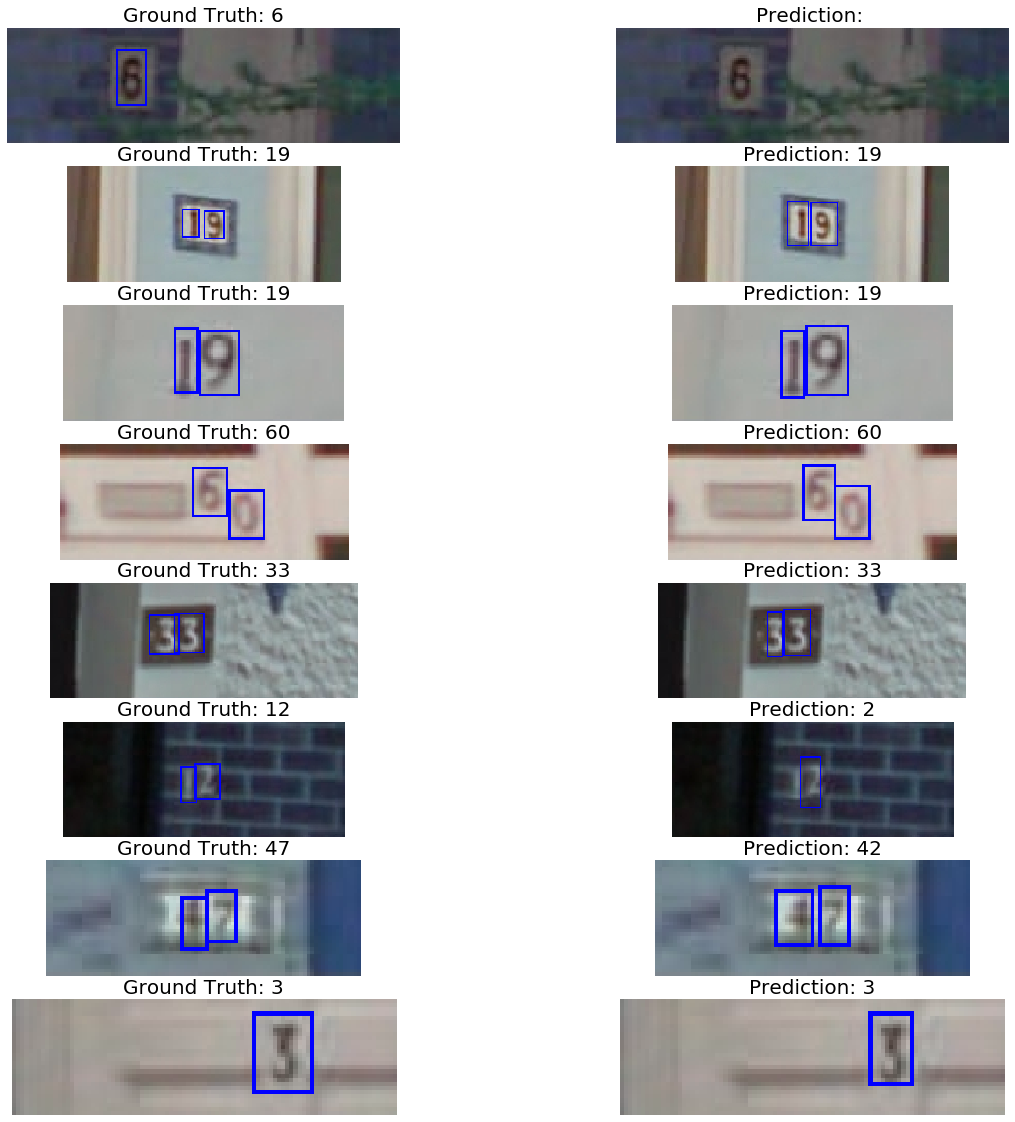

In [35]:
test_model(model, 8)